In [31]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Annotated, List
from dotenv import load_dotenv
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field
from langchain.prompts import PromptTemplate
import operator

In [32]:
load_dotenv()

True

In [33]:
model = ChatOpenAI(model="gpt-4o-mini")

In [34]:
class EvaluationSchema(BaseModel):
    feedback: str = Field(description="Detailed feedback for essay")
    score: int = Field(description="score out of 10", ge=0, le=10)

In [35]:
structured_model = model.with_structured_output(EvaluationSchema)

In [36]:
essay = """
Artificial Intelligence (AI) is characterised by machines that possess specific aspects of human intelligence, and encompass capabilities such as perception, learning, reasoning, problem-solving, language interaction, and even creative output. Over the past decade, AI has been integrated into the education space. It is being used to streamline students’ performance data in schools. For example, in Uttar Pradesh, the Nipun Assessment Test (NAT) is leveraging AI to assess the skills of 1.6 crore students across grades 1 to 8. AI also allows translation from one language to another, and provides individualised learning tools to students.

In the last year or so, a subset of AI—generative AI—has been gaining traction. Generative AI uses deep learning to analyse existing sets of data to create new outputs. Unlike its predecessors, generative AI also has reasoning capabilities. ChatGPT, which can produce human-like responses to text prompts, and DALL-E, which can create images and artworks from text prompts, are popular examples of generative AI. 

The rise of generative AI has raised curiosity and piqued interests. It’s early days and there’s no clear verdict, but its potential has opened up many possibilities. This article looks at some of these possibilities and highlights how generative AI can be effectively adopted in the education sector.

Generative AI in education
Generative AI can help bridge many gaps in a country like India that has vast cultural and social differences and barriers of inequality. It can be beneficial to various sets of stakeholders in the education system, be it students, teachers, or parents.

What is IDR Answers Page Banner
Recognising the importance of developing AI skills for children, CBSE has introduced AI as a skill module in classes 6–8 and as a skill subject in classes 9–12. Additionally, there are several organisations that are creating virtual assistants for students, teachers, and parents to enable them to learn and teach better. Many such initiatives are now being seen across a diverse set of use cases.

Here are some potential ways in which generative AI can be used:

1. Parents can leverage virtual assistants to figure out activities they can do with their child to help enhance their reading and comprehension skills. For example, parents can narrate stories generated by the AI to the child or get the child to read aloud a story. This can be especially useful for parents who aren’t literate but want to be involved in their child’s education.

2. Generative AI can help teachers follow the prescribed guidelines for teaching in an efficient way without spending hours going through multiple reading materials. A virtual assistant built on generative AI can assist a teacher in planning unique and engaging classroom activities by referring to a selection of carefully chosen documents and expert insights and suggesting methods that may work in a class setting.

3. This technology can adapt to the unique needs of a child and so, under the assistance of a caring adult (teacher, parent, or community member), it can be extremely helpful in early childhood education where learning pace and approaches vary from one child to another. It can be useful in developing foundational literacy and numeracy and teaching basic language skills.

donate banner
4. Generative AI can assist with speech-to-text, text-to-speech, and speech-to-speech translations, and also adjust the tone and cultural context while translating. This will help in making education more inclusive for children from various linguistic and sociocultural backgrounds. 

5. Generative AI can help create virtual labs on smartphones, especially for students in senior grades and colleges. This will be particularly useful for students from marginalised backgrounds who may not have access to a physical lab to perform science experiments or learn vocational skills. AI can aid in helping them understand these skills and concepts.

6. Virtual assistants can be used to resolve students’ doubts and queries and also help them in developing skills such as critical thinking, creativity, problem-solving, and communication. It can be a function of how one trains the virtual assistant to aid students in developing these skills. Students can speak with the virtual assistant in their local language, write and scan text, or type into it directly. Similarly, a school app that uses virtual assistants can be customised for students, teachers, and parents to track assignments, attendance, results, etc.
"""

In [ ]:
prompt = PromptTemplate(
    template="""Evaluate the language of the assay and provide the feedback and assign as score out of 10 \n {essay}""", input_variables=["essay"])
chain = prompt | structured_model
result = chain.invoke({"essay": essay})
result

EvaluationSchema(feedback='The language used in the essay is clear and concise, making complex topics accessible to a broad audience. The structure is logical, with a clear progression from introducing AI in the education sector to specific applications of generative AI, which aids in comprehension. The use of examples, such as the Nipun Assessment Test and specific roles for parents and teachers, effectively illustrates the potential impact of AI in education. However, the essay could benefit from elaborating on some points, particularly the challenges and concerns associated with the rise of generative AI, which would provide a more balanced perspective. Additionally, the piece could be more engaging with varied sentence structures to enhance readability. Overall, the essay demonstrates good knowledge of the subject matter and communicates it effectively.  ', score=8)

In [40]:
class UPSCState(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[List[int], operator.add]
    avg_score: float

In [51]:
parser = StrOutputParser()


def evaluate_langauge(state: UPSCState):
    prompt = PromptTemplate(
        template="""Evaluate the language of the essay and provide the feedback and assign as score out of 10 \n {essay}""", input_variables=["essay"])
    chain = prompt | structured_model
    output = chain.invoke({"essay": state["essay"]})
    return {"language_feedback": output.feedback, "individual_scores": [output.score]}


def evaluate_analysis(state: UPSCState):
    prompt = PromptTemplate(
        template="""Evaluate the depth of the ansalysis of the essay and provide the feedback and assign as score out of 10 \n {essay}""", input_variables=["essay"])
    chain = prompt | structured_model
    output = chain.invoke({"essay": state["essay"]})
    return {"analysis_feedback": output.feedback, "individual_scores": [output.score]}


def evaluate_thought(state: UPSCState):
    prompt = PromptTemplate(
        template="""Evaluate the clarity of thought essay and provide the feedback and assign as score out of 10 \n {essay}""", input_variables=["essay"])
    chain = prompt | structured_model
    output = chain.invoke({"essay": state["essay"]})
    return {"clarity_feedback": output.feedback, "individual_scores": [output.score]}


def final_evaluation(state: UPSCState):
    prompt = PromptTemplate(
        template="""Based on the following feedback create a summarize feedback \n language feedback - {language_feedback} \n depth of analysis feedback - {analysis_feedback} \n clarity of thought feedback - {clarity_feedback}""", input_variables=["language_feedback", "analysis_feedback", "clarity_feedback"])
    chain = prompt | model | parser
    output = chain.invoke({"language_feedback": state["language_feedback"],
                          "analysis_feedback": state["analysis_feedback"], "clarity_feedback": state["clarity_feedback"]})
    # Avg calculate
    avg_score = round(sum(state['individual_scores'])/len(state['individual_scores']),2)
    return {"overall_feedback": output, "avg_score": avg_score}

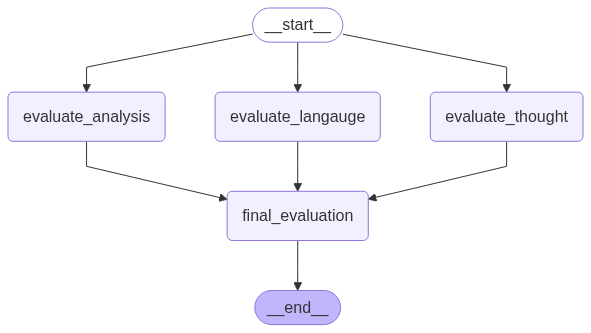

In [52]:
# Graph
graph = StateGraph(UPSCState)
# Node
graph.add_node("evaluate_langauge", evaluate_langauge)
graph.add_node("evaluate_analysis", evaluate_analysis)
graph.add_node("evaluate_thought", evaluate_thought)
graph.add_node("final_evaluation", final_evaluation)
# Edage
graph.add_edge(START,'evaluate_langauge')
graph.add_edge(START,'evaluate_analysis')
graph.add_edge(START,'evaluate_thought')
graph.add_edge("evaluate_langauge",'final_evaluation')
graph.add_edge("evaluate_analysis",'final_evaluation')
graph.add_edge("evaluate_thought",'final_evaluation')
graph.add_edge("final_evaluation",END)

# compile

workflow=graph.compile()
workflow

In [53]:
initial_state={
 "essay":essay   
}

final_state=workflow.invoke(initial_state)
final_state

{'essay': '\nArtificial Intelligence (AI) is characterised by machines that possess specific aspects of human intelligence, and encompass capabilities such as perception, learning, reasoning, problem-solving, language interaction, and even creative output. Over the past decade, AI has been integrated into the education space. It is being used to streamline students’ performance data in schools. For example, in Uttar Pradesh, the Nipun Assessment Test (NAT) is leveraging AI to assess the skills of 1.6 crore students across grades 1 to 8. AI also allows translation from one language to another, and provides individualised learning tools to students.\n\nIn the last year or so, a subset of AI—generative AI—has been gaining traction. Generative AI uses deep learning to analyse existing sets of data to create new outputs. Unlike its predecessors, generative AI also has reasoning capabilities. ChatGPT, which can produce human-like responses to text prompts, and DALL-E, which can create images